In [1260]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import pickle, random
from tqdm import tqdm
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

In [1261]:
#!pip install matplotlib

In [1262]:
#df0 = pd.read_csv('../spreadsheets/rlhf_20250104_6.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_159nlp.csv') # Best
#df0 = pd.read_csv('../spreadsheets/rlhf_1064_2.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_1072.csv')
#df0 = pd.read_csv('../spreadsheets/shufled_rlhf_11rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_12rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_15rl.csv')
df0 = pd.read_csv('../spreadsheets/rlhf_large_19rl.csv')

In [1263]:
df0['ask'] = df0['close'] * df0['volume']/(df0['close'] + df0['open'])

In [1264]:
df0['bid'] = df0['open'] * df0['volume']/(df0['close'] + df0['open'])

In [1265]:
#df0 = df0.reset_index(drop=True)

In [1266]:
df0.head()

,Unnamed: 0,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-25,...,sma-05,sma-07,sma-compare,is_short,action,imit-action,nlpreds,reward,ask,bid
0,0,5.1410,5.1970,5.085012,5.028747,5.1280,0,5.1820,5.238870e+05,5.017720,...,5.11100,5.100143,0,0,go_long,go_short,go_long,18.262565,2.629839e+05,2.609031e+05
1,1,1.2856,1.2926,1.228276,1.201880,1.2653,0,1.2730,8.511732e+07,1.203944,...,1.24868,1.235971,0,0,go_long,go_short,go_long,22.024575,4.234908e+07,4.276824e+07
2,2,1641.8000,1651.7000,1569.393352,1520.233894,1623.4000,1,1631.9000,3.749225e+03,1501.168000,...,1610.48000,1595.328571,0,0,go_long,go_short,go_long,6.066090,1.868943e+03,1.880282e+03
3,3,0.3091,0.3183,0.291754,0.281568,0.3068,0,0.3109,4.696476e+07,0.281972,...,0.29780,0.292829,0,0,go_long,go_short,go_long,20.780394,2.355055e+07,2.341420e+07
4,4,1.3441,1.3446,1.323429,1.316311,1.3376,0,1.3430,5.466880e+05,1.313832,...,1.32996,1.324543,0,0,go_long,go_short,go_long,16.955740,2.732321e+05,2.734559e+05


In [1267]:
df0.drop(['Unnamed: 0'], axis=1, inplace=True)

In [1268]:
df0['action'].value_counts()

action
go_long     139
go_short     10
Name: count, dtype: int64

In [1269]:
#action_mapping = {"go_long": 0, "go_short": 1}

In [1270]:
def prep_data(df: DataFrame) -> DataFrame:
    train_data = pd.DataFrame()
    for col in df.columns:
        col_name = col.split(' ')[0]
        train_data[f'{col_name}'] = df[col]

    return train_data

In [1271]:
train_data = df0 #prep_data(df0)

In [1272]:
train_data.head(2)

,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-25,long_jcrosk,...,sma-05,sma-07,sma-compare,is_short,action,imit-action,nlpreds,reward,ask,bid
0,5.1410,5.1970,5.085012,5.028747,5.1280,0,5.182,523887.0,5.017720,0,...,5.11100,5.100143,0,0,go_long,go_short,go_long,18.262565,2.629839e+05,2.609031e+05
1,1.2856,1.2926,1.228276,1.201880,1.2653,0,1.273,85117322.7,1.203944,0,...,1.24868,1.235971,0,0,go_long,go_short,go_long,22.024575,4.234908e+07,4.276824e+07


In [1273]:
new_cols = ['ask','bid','sma-compare','is_short']

In [1274]:
# Encode actions into numerical values
action_mapping = {"go_long": 0, "go_short": 1, "do_nothing": 2}
train_data["action_num"] = train_data["action"].map(action_mapping)

In [1275]:
# Define RL parameters
#states = train_data[["sma-05", "sma-07", "sma-25", "sma-compare", "is_short"]].values  # Include binary_state
states = train_data[new_cols].values
actions = list(action_mapping.values())  # Action space
rewards = train_data["reward"].values  # Rewards
n_states = states.shape[0]
n_actions = len(actions)

In [1276]:
# Initialize Q-table
q_table = np.zeros((n_states, n_actions))

In [1277]:
Hyperparameters = [
    [0.25, 0.95, 1.0, 0.99, 0.99, 10000],
    [0.9, 0.95, 1.0, 0.99, 0.99, 8000],
    [0.7, 0.75, 1.0, 0.97, 0.999, 28000],
    [0.05, 0.95, 1.0, 0.999, 0.995, 12000],
    [1, 0.95, 0.1, 0.96, 0.96, 12000],
    [0.25, 0.99, 0.01, 0.997, 0.99, 8000],
    [1, 0.75, 0.05, 0.999, 0.999, 10000],
    [0.01, 0.85, 0.01, 0.95, 0.95, 12000],
    [0.01, 0.99, 1.0, 0.95, 0.99, 16000],
    [0.05, 0.99, 0.5, 0.99, 0.997, 6000],
    [0.25, 0.95, 0.01, 0.997, 0.999, 14000],
    [0.01, 0.95, 1.0, 0.997, 0.995, 26000],
    [0.9, 0.99, 0.5, 0.995, 0.95, 12000],
    [1, 0.75, 0.005, 0.95, 0.95, 22000],
    [0.005, 0.75, 0.1, 0.95, 0.999, 12000],
    [0.25, 0.75, 0.01, 0.995, 0.999, 20000]
]

#print(*Hyperparameters[0])
'''
alpha = 1
gamma = 0.95
epsilon = 0.1
min_epsilon = 0.96
decay_rate = 0.96
n_episodes = 12000
'''

alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes = Hyperparameters[8] # 7, 8,9



In [1278]:
def create_state_index_mapping(df):
    state_to_index = {}
    for idx, row in df.iterrows():
        state = (row['ask'], row['bid'], row['sma-compare'], row['is_short'])
        state_to_index[state] = idx
    return state_to_index

# Assuming 'df' is your dataframe used during training
state_to_index = create_state_index_mapping(train_data)

# Save the state_to_index dictionary for later use
np.save('bids_state_to_index.npy', state_to_index)


In [1279]:
# Helper function to choose an action using epsilon-greedy
def choose_action(state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.randint(0, n_actions)  # Explore: random action
    else:
        return np.argmax(q_table[state])  # Exploit: best known action

evaluating results per episode ...:   0%|          | 0/16000 [00:00<?, ?it/s]

evaluating results per episode ...:   2%|▏         | 384/16000 [00:00<00:07, 1975.81it/s]

Episode 0/16000 - Total Reward: -986.2205778200002, Epsilon: 0.99
Episode 400/16000 - Total Reward: -2866.025821189999, Epsilon: 0.95


evaluating results per episode ...:   6%|▋         | 1040/16000 [00:00<00:06, 2151.09it/s]

Episode 800/16000 - Total Reward: -1319.88973503, Epsilon: 0.95
Episode 1200/16000 - Total Reward: -2866.025821189999, Epsilon: 0.95


evaluating results per episode ...:  12%|█▏        | 1934/16000 [00:00<00:06, 2210.35it/s]

Episode 1600/16000 - Total Reward: -2249.6299521799997, Epsilon: 0.95
Episode 2000/16000 - Total Reward: -2174.10266087, Epsilon: 0.95


evaluating results per episode ...:  18%|█▊        | 2832/16000 [00:01<00:06, 2182.25it/s]

Episode 2400/16000 - Total Reward: -2296.9450470300003, Epsilon: 0.95
Episode 2800/16000 - Total Reward: -1807.4851080099997, Epsilon: 0.95


evaluating results per episode ...:  22%|██▏       | 3496/16000 [00:01<00:05, 2127.31it/s]

Episode 3200/16000 - Total Reward: -320.60883263999995, Epsilon: 0.95
Episode 3600/16000 - Total Reward: -1693.4320567199998, Epsilon: 0.95


evaluating results per episode ...:  28%|██▊       | 4522/16000 [00:02<00:06, 1700.83it/s]

Episode 4000/16000 - Total Reward: -2524.1319554699994, Epsilon: 0.95
Episode 4400/16000 - Total Reward: -910.9365453, Epsilon: 0.95


evaluating results per episode ...:  32%|███▏      | 5191/16000 [00:02<00:05, 2047.52it/s]

Episode 4800/16000 - Total Reward: -1693.4320567199998, Epsilon: 0.95
Episode 5200/16000 - Total Reward: -910.9365453, Epsilon: 0.95


evaluating results per episode ...:  37%|███▋      | 5843/16000 [00:02<00:04, 2134.18it/s]

Episode 5600/16000 - Total Reward: -1807.4851080099997, Epsilon: 0.95
Episode 6000/16000 - Total Reward: -142.65469052, Epsilon: 0.95


evaluating results per episode ...:  42%|████▏     | 6726/16000 [00:03<00:04, 2087.51it/s]

Episode 6400/16000 - Total Reward: -1176.31178565, Epsilon: 0.95
Episode 6800/16000 - Total Reward: -1833.6516572299997, Epsilon: 0.95


evaluating results per episode ...:  48%|████▊     | 7615/16000 [00:03<00:03, 2195.36it/s]

Episode 7200/16000 - Total Reward: -4.47817095, Epsilon: 0.95
Episode 7600/16000 - Total Reward: -2273.9953251300003, Epsilon: 0.95


evaluating results per episode ...:  52%|█████▏    | 8290/16000 [00:03<00:03, 2223.36it/s]

Episode 8000/16000 - Total Reward: -1267.6163406400003, Epsilon: 0.95
Episode 8400/16000 - Total Reward: -176.63243193, Epsilon: 0.95


evaluating results per episode ...:  58%|█████▊    | 9215/16000 [00:04<00:02, 2272.70it/s]

Episode 8800/16000 - Total Reward: -2951.055115549999, Epsilon: 0.95
Episode 9200/16000 - Total Reward: -2856.727329529999, Epsilon: 0.95


evaluating results per episode ...:  62%|██████▏   | 9933/16000 [00:04<00:02, 2345.23it/s]

Episode 9600/16000 - Total Reward: -1864.5293831199997, Epsilon: 0.95
Episode 10000/16000 - Total Reward: -2598.0379623199988, Epsilon: 0.95


evaluating results per episode ...:  67%|██████▋   | 10641/16000 [00:05<00:02, 2243.20it/s]

Episode 10400/16000 - Total Reward: -454.07197213, Epsilon: 0.95
Episode 10800/16000 - Total Reward: -351.08821038, Epsilon: 0.95


evaluating results per episode ...:  72%|███████▏  | 11562/16000 [00:05<00:01, 2282.44it/s]

Episode 11200/16000 - Total Reward: -1891.36881322, Epsilon: 0.95
Episode 11600/16000 - Total Reward: -1447.04150548, Epsilon: 0.95


evaluating results per episode ...:  78%|███████▊  | 12469/16000 [00:05<00:01, 2228.80it/s]

Episode 12000/16000 - Total Reward: -421.00621423, Epsilon: 0.95
Episode 12400/16000 - Total Reward: -2598.0379623199988, Epsilon: 0.95


evaluating results per episode ...:  82%|████████▏ | 13144/16000 [00:06<00:01, 1871.11it/s]

Episode 12800/16000 - Total Reward: -1218.2087517100001, Epsilon: 0.95


evaluating results per episode ...:  86%|████████▌ | 13787/16000 [00:06<00:01, 2027.16it/s]

Episode 13200/16000 - Total Reward: -4.47817095, Epsilon: 0.95
Episode 13600/16000 - Total Reward: -2368.2467664799997, Epsilon: 0.95


evaluating results per episode ...:  92%|█████████▏| 14695/16000 [00:06<00:00, 2137.78it/s]

Episode 14000/16000 - Total Reward: -2672.674842059999, Epsilon: 0.95
Episode 14400/16000 - Total Reward: -521.01221639, Epsilon: 0.95


evaluating results per episode ...:  95%|█████████▍| 15149/16000 [00:07<00:00, 2163.74it/s]

Episode 14800/16000 - Total Reward: -2716.229263109999, Epsilon: 0.95
Episode 15200/16000 - Total Reward: -1644.95274931, Epsilon: 0.95


evaluating results per episode ...: 100%|██████████| 16000/16000 [00:07<00:00, 2127.12it/s]

Episode 15600/16000 - Total Reward: -2344.6286124, Epsilon: 0.95


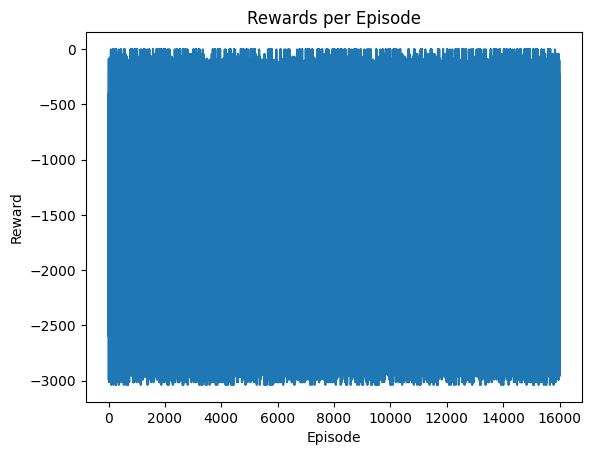

In [1280]:

# Set random seed for reproducibility and train the loop
np.random.seed(42)
random.seed(42)
# Initialize a list to store rewards per episode
rewards_per_episode = []

for episode in tqdm(range(n_episodes), desc="evaluating results per episode ..."):
    current_state = np.random.randint(0, n_states)  # Random initial state
    total_reward = 0  # Initialize total reward for the current episode

    while current_state < n_states - 1:
        action = choose_action(current_state, epsilon)
        
        next_state = current_state + 1  # This depends on your environment logic
        reward = rewards[next_state]

        best_next_action = np.argmax(q_table[next_state])
        q_table[current_state, action] += alpha * (
            reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
        )
        
        total_reward += reward  # Accumulate reward for the current episode
        current_state = next_state  # Move to next state

    rewards_per_episode.append(total_reward)  # Store the total reward for the current episode

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * decay_rate)

    # Optional: Log progress
    if episode % 400 == 0:  # Adjust logging frequency as needed
        print(f"Episode {episode}/{n_episodes} - Total Reward: {total_reward}, Epsilon: {epsilon}")

# Example: Save the Q-table
np.save("bids_q_table.npy", q_table)

# Example: Plotting the rewards
import matplotlib.pyplot as plt

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()



In [1281]:
def load_q_table(file_path):
    return np.load(file_path)

def load_state_index_mapping(file_path):
    return np.load(file_path, allow_pickle=True).item()

loaded_mapping = load_state_index_mapping(file_path="bids_state_to_index.npy")
loaded_qtable = load_q_table(file_path="bids_q_table.npy")

In [1282]:
#state = (row['open'], row['high'], row['ema-26'], row['ema-12'], row['low'], \
#                 row['mean-grad-hist'], row['close'], row['volume'], row['sma-25'], \
#                 row['long_jcrosk'], row['short_kdj'], row['sma-compare'], row['is_short'])

def prep_state(
                ask: float, bid: float, sma_compare: int, is_short: int
            ):
    state = np.array([[ask, bid, sma_compare, is_short]])
    if not np.all(np.isfinite(state)):
        state = np.nan_to_num(state, nan=0.0, posinf=0.0, neginf=0.0)
    return state


In [1283]:

def predict_action(state, q_table, state_to_index, action_mapping, default_action: str = None):
    state_tuple = tuple(state.flatten())

    state_index = state_to_index.get(state_tuple, -1)

    if not state_index == -1:
        try:
            q_values = q_table[state_index]
        except ValueError as e:
            print(e)
            #return default_action
    else:
        state_tuples = list(state_to_index.keys())
        kdtree = KDTree(state_tuples)
        distance, index = kdtree.query(state.flatten())
        nearest_state_tuple = state_tuples[index]
        new_state_index = state_to_index[nearest_state_tuple]
        q_values = loaded_qtable[new_state_index]
    
    #q_values = q_table[state_index]
    best_action_index = np.argmax(q_values)
    action = [action for action, index in action_mapping.items() if index == best_action_index][0]
    return action

In [1284]:
# Predict an entire range
for idx, row in train_data.iterrows():
    state = row[['ask','bid','sma-compare', 'is_short']].values
    action = predict_action(state, q_table, state_to_index, action_mapping)
    train_data.loc[idx, "predicted_action"] = action

In [1285]:
#train_data.tail(15)
len(q_table)

149

In [1286]:
train_data['predicted_action'].value_counts()

predicted_action
go_short      52
go_long       49
do_nothing    48
Name: count, dtype: int64

In [1287]:
m = train_data[(train_data['predicted_action'] == 'go_long') & (train_data['reward'] > 0)]
m['is_short'].value_counts()

is_short
0    6
1    3
Name: count, dtype: int64

In [1288]:
longs = dict(m['is_short'].value_counts().items()).get(0)
print(longs)
shorts = dict(m['is_short'].value_counts().items()).get(1)
print(shorts)

6
3


In [1289]:
# Performance measures
# Initialize cumulative rewards
cumulative_predicted_reward = 0
cumulative_actual_reward = 0

# Iterate through states to calculate rewards
for state_index in range(n_states - 1):
    # Predicted action from Q-table
    predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
    # Actual action from the ground truth
    actual_action = train_data["action_num"].iloc[state_index]

    # Get reward for predicted action only if it matches the actual action
    if predicted_action == actual_action:
        predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
        cumulative_predicted_reward += predicted_reward

    # Get actual reward for the ground truth action
    actual_reward = rewards[state_index + 1]
    cumulative_actual_reward += actual_reward

    # Optional: Log progress
    if state_index % 100 == 0:  # Adjust logging frequency as needed
        print(f"Processed state {state_index}/{n_states - 1}")
        print(f"Current Predicted Reward: {cumulative_predicted_reward}")
        print(f"Current Actual Reward: {cumulative_actual_reward}")

# Print results
print(f"Cumulative Predicted Reward: {cumulative_predicted_reward}")
print(f"Cumulative Actual Reward: {cumulative_actual_reward}")

# Optionally calculate efficiency
efficiency = (
    ((cumulative_predicted_reward - cumulative_actual_reward) / abs(cumulative_actual_reward)) * 100
    if cumulative_actual_reward != 0
    else 0
)
print(f"Prediction Efficiency: {efficiency:.2f}%")



Processed state 0/148
Current Predicted Reward: 22.02457531
Current Actual Reward: 22.02457531
Processed state 100/148
Current Predicted Reward: -487.30497683
Current Actual Reward: -1778.9921506499993
Cumulative Predicted Reward: -852.17613982
Cumulative Actual Reward: -2790.900529969999
Prediction Efficiency: 69.47%


In [1290]:
# Accuracy
correct_predictions = 0
for state_index in range(n_states):
    predicted_action = np.argmax(q_table[state_index])  # Predicted action
    actual_action = train_data["action_num"].iloc[state_index]  # Actual action
    if predicted_action == actual_action:
        correct_predictions += 1

accuracy = correct_predictions / n_states
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 32.21%


In [1291]:
# Confusion matrix
y_true = train_data["action_num"]  # Actual actions
y_pred = [np.argmax(q_table[state_index]) for state_index in range(n_states)]  # Predicted actions

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[44 48 47]
 [ 5  4  1]
 [ 0  0  0]]


In [1304]:
def confusion_accuracy(conf_matrix, n_states):
    # True Positives (TP): Diagonal elements of the confusion matrix
    TP = conf_matrix[0][0] + conf_matrix[1][1] + conf_matrix[2][2]
    # **True Positives**: 16 (class 0), 0 (class 1), 0 (class 2)
    return TP/n_states

In [1307]:
con_acc = accuracy(cm, n_states=n_states)
print(f"confusion accuracy: {con_acc:.2f}%")

confusion accuracy: 0.32%


In [1292]:
df0['predicted_action'].value_counts()

predicted_action
go_short      52
go_long       49
do_nothing    48
Name: count, dtype: int64

In [1293]:
def action_reward(action: str, is_short: int):
    m = train_data[(train_data['predicted_action'] == f'{action}') & (train_data['is_short'] == is_short)]
    counts = m['is_short'].value_counts()
    return {
        'counts': counts.get(is_short),
        'total_reward': m['reward'].cumsum()[-1:].values[0],
        'wins': len(m[m['reward'] > 0]),
        'losses': len(m[m['reward'] <= 0])
    }

In [1303]:
print(action_reward('do_nothing', 0)) # go_short 1

{'counts': 47, 'total_reward': -943.8184022200002, 'wins': 7, 'losses': 40}


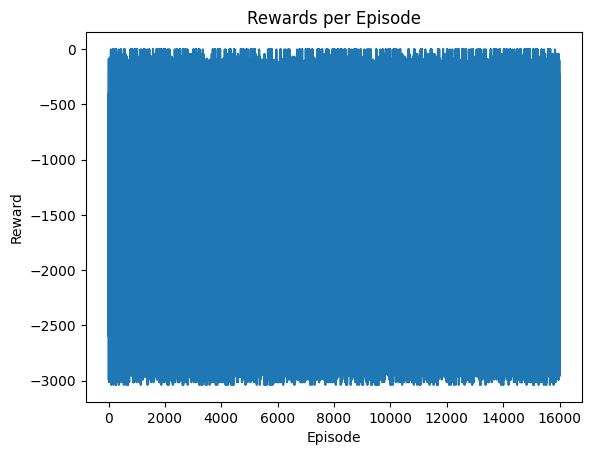

In [1295]:
import matplotlib.pyplot as plt

# Assuming you have a list of rewards for each episode
#rewards_per_episode = [...]  # Populate this with your actual data

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()


In [1296]:
# Tuning

def train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards):
    q_table = np.zeros((n_states, n_actions))
    rewards_per_episode = []

    for episode in range(n_episodes):
        current_state = np.random.randint(0, n_states)
        total_reward = 0

        while current_state < n_states - 1:
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(0, n_actions)
            else:
                action = np.argmax(q_table[current_state])

            next_state = current_state + 1  # Adjust based on environment logic
            reward = rewards[next_state]

            best_next_action = np.argmax(q_table[next_state])
            q_table[current_state, action] += alpha * (
                reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
            )

            total_reward += reward
            current_state = next_state

        rewards_per_episode.append(total_reward)
        epsilon = max(min_epsilon, epsilon * decay_rate) # default min_epsilon = 0.01

    return q_table, rewards_per_episode


In [1297]:

def evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards):
    correct_predictions = 0
    total_reward = 0
    reward_weighted_accuracy = []

    # Add tqdm for progress visualization
    for state_index in tqdm(range(n_states), desc="Evaluating States"):
        predicted_action = np.argmax(q_table[state_index])  # Predicted action
        actual_action = train_data["action_num"].iloc[state_index]  # Actual action
        reward = rewards[state_index]  # Reward for the action

        if predicted_action == actual_action:
            correct_predictions += 1
            total_reward += reward

        accuracy = correct_predictions / (state_index + 1)
        reward_weighted_accuracy.append(total_reward / (state_index + 1))

        # Optional: Log progress
        if state_index % 100 == 0:
            print(f"Processed state {state_index}/{n_states} - Accuracy: {accuracy * 100:.2f}%, Reward-weighted Accuracy: {reward_weighted_accuracy[-1]}")

    final_reward_weighted_accuracy = total_reward / n_states
    return final_reward_weighted_accuracy * 100



In [1298]:
'''
def random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_reward_weighted_accuracy = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)

        if reward_weighted_accuracy > best_reward_weighted_accuracy:
            best_reward_weighted_accuracy = reward_weighted_accuracy
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration Reward-weighted Accuracy: {reward_weighted_accuracy:.2f}%, Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")

    return best_params, best_reward_weighted_accuracy

# Define the parameter grid
param_grid = {
    'alpha': [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000]
}

# Perform Random Search
best_params, best_reward_weighted_accuracy = random_search_reward_weighted(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")

'''

'\ndef random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_reward_weighted_accuracy = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)\n\n        if reward_weighted_accuracy > best_reward_weighted_accuracy:\n            best_reward_weighted_accuracy = reward_weighted_accuracy\n        

In [1299]:
def evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards):
    # Initialize cumulative rewards
    cumulative_predicted_reward = 0
    cumulative_actual_reward = 0

    # Iterate through states to calculate rewards
    for state_index in range(n_states - 1):
        # Predicted action from Q-table
        predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
        # Actual action from the ground truth
        actual_action = train_data["action_num"].iloc[state_index]

        # Get reward for predicted action only if it matches the actual action
        if predicted_action == actual_action:
            predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
            cumulative_predicted_reward += predicted_reward

        # Get actual reward for the ground truth action
        actual_reward = rewards[state_index + 1]
        cumulative_actual_reward += actual_reward
    return cumulative_predicted_reward

In [1300]:
'''
def random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_cumulative_pred_reward = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)

        if cumulative_pred_reward > best_cumulative_pred_reward:
            best_cumulative_pred_reward = cumulative_pred_reward
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration cumulative predicted reward: {cumulative_pred_reward:.2f}%, Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")

    return best_params, best_cumulative_pred_reward

# Define the parameter grid
param_grid = {
    'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000, 14000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000]
}
# 1500, 4000,6000, 8000, 9000, 10000, 11000, 
# Perform Random Search
best_params, best_cumulative_pred_reward = random_search_prediction_efficiency(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")
'''

'\ndef random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_cumulative_pred_reward = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)\n\n        if cumulative_pred_reward > best_cumulative_pred_reward:\n            best_cumulative_pred_reward = cumulative_pred_reward\n        